In [29]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.base import BaseEstimator
from sklearn.datasets import load_breast_cancer, load_boston
from sklearn.model_selection import train_test_split

In [501]:
from sklearn.metrics import mean_squared_error, log_loss, roc_auc_score, accuracy_score
from sklearn.tree import DecisionTreeRegressor

In [518]:
class GradientBoosting(BaseEstimator):

    def one_zero_change(self, x, x_min=1e-7):
        _x = x.copy()
        _x = np.where(_x < x_min, x_min, _x)
        _x = np.where(_x > (1 - x_min), 1 - x_min, _x)
        return _x
    
    def sigma(self, z):
        _z = z.copy()
        _z = np.where(_z > 100, 100, _z)
        _z = np.where(_z < -100, -100, _z)
        return 1. / (1 + np.exp(-_z))

    def log_loss_grad(self, y, p):
        return (y - p) / (self.one_zero_change(p) * (1 - self.one_zero_change(p)))
    
    def mse_grad(self, y, p):
        return ((p - y) * 2) / len(y)
    
    def rmsle(self, y, p):
        return np.sum((np.log(p + 1) - np.log(y + 1)) ** 2) / len(y)

    def rmsle_grad(self, y, p):
        return np.log((p + 1) / (y + 1)) / (len(y) * (self.one_zero_change(p) + 1) * self.rmsle(y, p))

    def __init__(self, loss='mse', n_estimators=10, learning_rate=1e-2, max_depth=3, random_state=17):
        self.params = {}
        self.params['loss'] = loss
        self.params['n_estimators'] = n_estimators
        self.params['learning_rate'] = learning_rate
        self.params['max_depth'] = max_depth
        self.params['random_state'] = random_state
        
        self.is_clf = False
        
        if self.params['loss'] == 'mse':
            self.loss_func = mean_squared_error
            self.loss_grad = self.mse_grad
        elif self.params['loss'] == 'rmsle':
            self.loss_func = self.rmsle
            self.loss_grad = self.rmsle_grad
        elif self.params['loss'] == 'log_loss':
            self.loss_func = log_loss
            self.loss_grad = self.log_loss_grad
            self.is_clf = True
        else:
            raise ValueError(f'loss param "{loss}" not found')
            
        self.loss_by_iter_ = []
        self.residuals_by_iter_ = []
        self.trees_ = []
        self.b0 = None
        
        super(GradientBoosting, self).set_params(**self.params)
    
    def fit(self, X, y):
        X_mod = X
        self.b0 = y.mean()
        y_pred = [[self.b0]] * len(y)
        y_pred = np.array(y_pred)

        for i in range(self.params['n_estimators']):
            grad = self.loss_grad(y, y_pred)
            r = -1 * grad
            b = DecisionTreeRegressor(max_depth=self.params['max_depth'], 
                                      random_state=self.params['random_state']).fit(X, r)
            self.trees_.append(b)
            y_pred = self.predict_proba(X)
            loss = self.loss_func(y, y_pred)
            self.loss_by_iter_.append(loss)
            self.residuals_by_iter_.append(r)

        return self
    
    def predict_proba(self, X):
        if self.b0 is None:
            raise RuntimeError('First do run "fit" function')
        y_pred = self.b0
        for tree in self.trees_:
            y_pred_i = tree.predict(X).reshape(-1, 1)
            y_pred_i = y_pred_i * self.params['learning_rate']
            y_pred += y_pred_i
        if self.is_clf:
            return 1 - self.sigma(y_pred)
        return y_pred
    
    def predict(self, X):
        y_pred = self.predict_proba(X)
        if self.is_clf:
            return np.where(y_pred < 0.5, 0, 1)
        return y_pred

In [519]:
X_regr_toy = np.arange(7).reshape(-1, 1)
y_regr_toy = ((X_regr_toy - 3) ** 2).astype('float64')

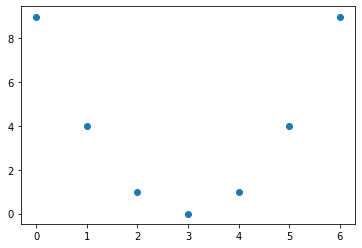

In [520]:
plt.scatter(X_regr_toy, y_regr_toy);

In [521]:
gb = GradientBoosting(loss='mse', n_estimators=200, learning_rate=1e-1, max_depth=3, random_state=17)
gb.fit(X_regr_toy, y_regr_toy)

GradientBoosting(learning_rate=0.1, loss='mse', max_depth=3, n_estimators=200,
                 random_state=17)

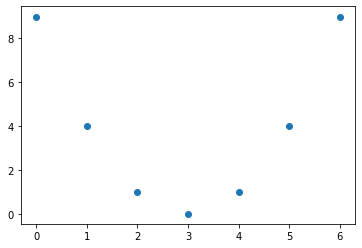

In [522]:
y_pred = gb.predict(X_regr_toy)
plt.scatter(X_regr_toy, y_pred);

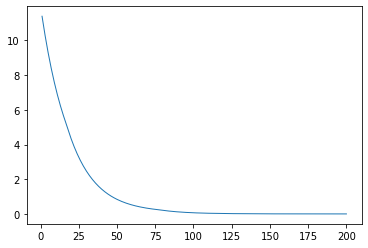

In [523]:
plt.plot(range(1, len(gb.loss_by_iter_)+1), gb.loss_by_iter_, linewidth=1);

In [524]:
gb = GradientBoosting(loss='rmsle', n_estimators=200, learning_rate=1e-1, max_depth=3, random_state=17)
gb.fit(X_regr_toy, y_regr_toy)

GradientBoosting(learning_rate=0.1, loss='rmsle', max_depth=3, n_estimators=200,
                 random_state=17)

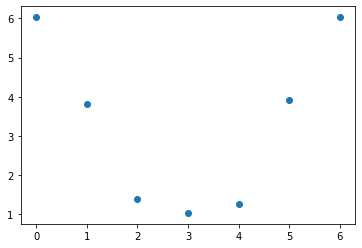

In [525]:
y_pred = gb.predict(X_regr_toy)
plt.scatter(X_regr_toy, y_pred);

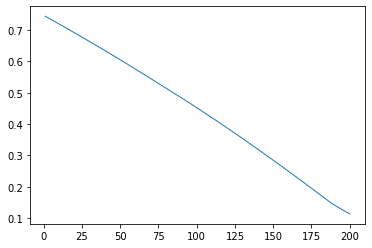

In [526]:
plt.plot(range(1, len(gb.loss_by_iter_)+1), gb.loss_by_iter_, linewidth=1);

In [527]:
X_clf_toy = np.c_[np.arange(7), (np.arange(7) - 3) ** 2]
y_clf_toy = np.array([0, 1, 0, 1, 0, 1, 0]).reshape(-1, 1)

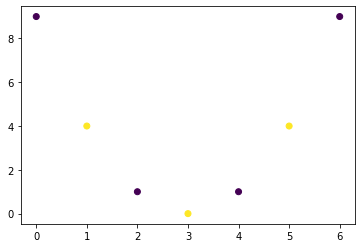

In [528]:
plt.scatter(X_clf_toy[:, 0], X_clf_toy[:, 1], c=y_clf_toy.reshape(-1));

In [529]:
gb = GradientBoosting(loss='log_loss', n_estimators=10, learning_rate=0.05, max_depth=3, random_state=17)
gb.fit(X_clf_toy, y_clf_toy)

GradientBoosting(learning_rate=0.05, loss='log_loss', max_depth=3,
                 n_estimators=10, random_state=17)

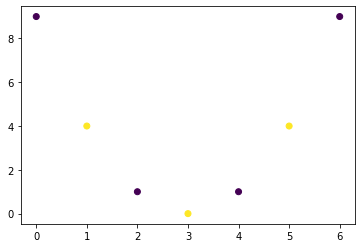

In [530]:
y_pred = gb.predict(X_clf_toy)
plt.scatter(X_clf_toy[:, 0], X_clf_toy[:, 1], c=y_pred.reshape(-1));

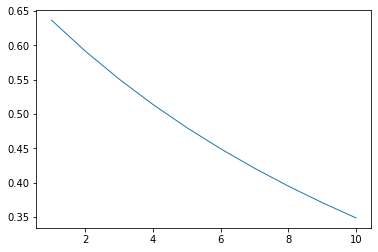

In [531]:
plt.plot(range(1, len(gb.loss_by_iter_)+1), gb.loss_by_iter_, linewidth=1);

In [532]:
boston = load_boston()
X, y = boston.data, boston.target.reshape(-1, 1)

In [533]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

In [534]:
gb = GradientBoosting(loss='mse', n_estimators=300, learning_rate=3, max_depth=10, random_state=17)
gb.fit(X_train, y_train)

GradientBoosting(learning_rate=3, loss='mse', max_depth=10, n_estimators=300,
                 random_state=17)

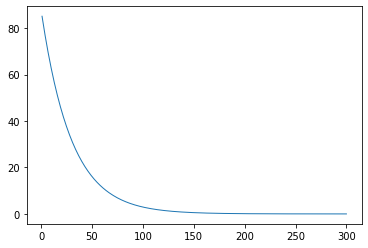

In [535]:
plt.plot(range(1, len(gb.loss_by_iter_)+1), gb.loss_by_iter_, linewidth=1);

In [536]:
gb.loss_by_iter_[-1]

0.006142065060583258

In [537]:
y_pred = gb.predict(X_test)

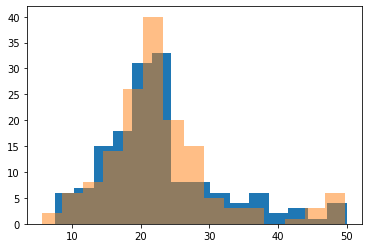

In [538]:
plt.hist(y_test, bins=15)
plt.hist(y_pred, alpha=0.5, bins=15);

In [539]:
mean_squared_error(y_test, y_pred)

10.060429965696104

In [540]:
cancer = load_breast_cancer()
X, y = cancer.data, cancer.target.reshape(-1, 1)

In [541]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

In [542]:
gb = GradientBoosting(loss='log_loss', n_estimators=200, learning_rate=1e-2, max_depth=3, random_state=17)
gb.fit(X_train, y_train)

GradientBoosting(learning_rate=0.01, loss='log_loss', max_depth=3,
                 n_estimators=200, random_state=17)

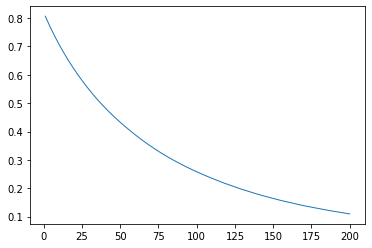

In [543]:
plt.plot(range(1, len(gb.loss_by_iter_)+1), gb.loss_by_iter_, linewidth=1);

In [544]:
y_pred = gb.predict(X_test)
y_pred_proba = gb.predict_proba(X_test)

In [545]:
roc_auc_score(y_test, y_pred_proba), accuracy_score(y_test, y_pred)

(0.9807749627421759, 0.9649122807017544)